# **Support Vector Machines(SVM)**

**Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.**

# Import Libraries

In [1]:
import copy
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC

# Load Data

In [2]:
def get_data(set_type):
    print('DataSet =', set_type)
    if   set_type == 'Linear SVM':
        mat_contents = loadmat('../input/hw-5-data/Dataset1.mat') 
        x = np.asmatrix(mat_contents['X'])
        y = np.asmatrix(mat_contents['y']).astype(int)
        x_norm = preprocessing.minmax_scale(x, axis=0)
        x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.20, random_state = 0) 
    
    elif set_type == 'Kernel SVM A1':
        mat_contents = loadmat('../input/hw-5-data/Dataset2.mat') 
        x = np.asmatrix(mat_contents['X'])
        y = np.asmatrix(mat_contents['y']).astype(int)
        x_norm = preprocessing.minmax_scale(x, axis=0)
        x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.20, random_state = 0) 
    
    elif set_type == 'Kernel SVM A2':
        dataset = np.loadtxt('../input/hw-5-data/Health.dat', delimiter=' ', dtype='float') 
        x = dataset[:,:dataset.shape[1]-1]
        y = dataset[:, dataset.shape[1]-1].astype(int)
        x_norm = preprocessing.minmax_scale(x, axis=0)
        x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.20, random_state = 0) 
        y_train = np.asmatrix(y_train).T
        y_test = np.asmatrix(y_test).T
    
    elif set_type == 'Kernel SVM B':
        dataset = np.loadtxt('../input/hw-5-data/Vehicle.dat', delimiter=';', dtype='str')         
        x = dataset[:,:dataset.shape[1]-1].astype(int)
        y = dataset[:, dataset.shape[1]-1]
        x_norm = preprocessing.minmax_scale(x, axis=0)
        x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.20, random_state = 0) 
        y_train = np.asmatrix(y_train).T
        y_test = np.asmatrix(y_test).T 
    
    x = np.append(x_train, x_test, axis=0)
    y = np.append(y_train, y_test, axis=0)
    x = x.astype(float)
    y = y.astype(int)
    n = x.shape[1]
    k = len(np.unique(y, axis=0))
    return x, y, n, k

# Plots Functions

In [3]:
def PlotScatter2D(x, y, title):
    classes = np.unique(np.ravel(y))
    
    fig = plt.figure(figsize=(12,9))
    ax0 = fig.add_subplot(111)
    colors = ['b','r','g','c','m','y','k','lime','brown','gold']
    for class_name,c,m in zip(classes,['b','r','g','c','m','y','k','lime','brown','gold'],['s','x','o','*','+','D','v','p','|','_']):
        calss_index = np.where(classes == class_name)[0][0]
        class_filter = np.ravel(y[:]==class_name)
        ax0.scatter(np.ravel(x[class_filter, 0]),
                    np.ravel(x[class_filter, 1]),
                    c=colors[calss_index], label=class_name, s=30, cmap='coolwarm')
    plt.legend() 
    plt.title(title)
    return ax0

In [4]:
def PlotSVM(fig, X, Y, clf, i, c):
    ax0 = fig.add_subplot(1, 2, i + 1)
    ax0.scatter(np.ravel(X[:, 0]), np.ravel(X[:, 1]), c=np.ravel(Y), s=30, cmap='coolwarm')
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax0.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    decision_function = clf.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]
    ax0.scatter(np.ravel(support_vectors[:, 0]), np.ravel(support_vectors[:, 1]), s=100, linewidth=1,facecolors='none', edgecolors='k')
    
    plt.title("C=" + str(c))
    return ax0


In [5]:
def PlotKernelSVM(fig, X, Y, C, clf, i, c):
    ax0 = fig.add_subplot(round(len(C)/2)+1, 2, i + 1)
    ax0.scatter(np.ravel(X[:, 0]), np.ravel(X[:, 1]), c=np.ravel(Y), s=10, cmap='coolwarm')
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)) 
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax0.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    decision_function = clf.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]
    ax0.scatter(np.ravel(support_vectors[:, 0]), np.ravel(support_vectors[:, 1]), s=50, linewidth=.5,facecolors='none', edgecolors='k')
    
    plt.title(str(c))
    return ax0

In [6]:
def PlotResults(ax, ay, atitle):
    fig = plt.figure(figsize=(6,4))
    ax0 = fig.add_subplot(111)
    ax0.plot(np.ravel(ax), np.ravel(ay), )   
    ax0.set(xlabel="Index Of C", ylabel='Accuracy', title=atitle)
    ax0.grid()
    plt.title(atitle)
    return ax0

# Popular SVM Kernel Functions

In [7]:
def LinearSVM(x, y, n, k, C):
    fig = plt.figure(figsize=(12, 5))
    
    for i in range(0, len(C)):
        clf = svm.SVC(kernel='linear', C=C[i])
        clf.fit(x, np.ravel(y))
        
        y_pred = clf.predict(x)
        print('Train Accuracy for C=' + str(C[i]) + ' :',accuracy_score(np.ravel(y), y_pred))
        
        PlotSVM(fig, x, y, clf, i, C[i])

    plt.tight_layout()
    plt.show()

In [8]:
def KernelSVM(set_type, x, y, n, k, C, n_time, n_fold, print_plots=False):
    fig = plt.figure(figsize=(12, 20))
    result = np.zeros((len(C), n_time, n_fold, 2))
    for i in range(0, len(C)):
        for t in range(0, n_time):
            d = np.append(x, y, axis=1)
            np.random.shuffle(d)
            x = d[:, :-1]
            y = d[:,  -1].astype(int)
            j = 0
            skf = StratifiedKFold(n_fold)

            for train_index, test_index in skf.split(x, y):
                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index].astype(int), y[test_index].astype(int)
                            
                clf = svm.SVC(kernel='rbf', C=C[i])
                clf.fit(x_train, np.ravel(y_train))
                
                y_train_pred = clf.predict(x_train)
                y_test_pred = clf.predict(x_test)
                
                train_accuracy = accuracy_score(np.ravel(y_train), y_train_pred)
                test_accuracy = accuracy_score(np.ravel(y_test), y_test_pred)
                result[i, t, j, 0] = train_accuracy
                result[i, t, j, 1] = test_accuracy
                
                j += 1
                
        if print_plots:
            PlotKernelSVM(fig, x, y, C, clf, i, 'Test DataSet = ' + set_type + ' , C=' + str(C[i]))
                
    
    C_Accuracy = np.zeros((len(C), 2))
    for i in range(0, len(C)):
        C_Accuracy[i, 0] = C[i]
        C_Accuracy[i, 1] = np.mean(result[i,:,:,:])
    
    best_c = C_Accuracy[np.argmax(C_Accuracy[:, 1]), 0]
    best_c_accuracy = C_Accuracy[np.argmax(C_Accuracy[:, 1]), 1]
    print('Best Accuracy is for C=' + str(best_c) + ' :', str(best_c_accuracy) )
    
    if set_type == 'Kernel SVM A1':
        clf_best = svm.SVC(kernel='rbf', C=best_c)
        clf_best.fit(x_train, np.ravel(y_train))
        fig = plt.figure(figsize=(19.4, 7.5))    
        PlotSVM(fig, x, y.astype(int), clf_best, 0, best_c)
        plt.tight_layout()
        plt.show()
    
    return C_Accuracy, result

In [9]:
def KernelSVM_MultiClass(set_type, x, y, n, k, C, n_time, n_fold, print_plots=False):
    fig = plt.figure(figsize=(12, 20))
    result = np.zeros((len(C), n_time, n_fold, 2))
    for i in range(0, len(C)):
        for t in range(0, n_time):
            d = np.append(x, y, axis=1)
            np.random.shuffle(d)
            x = d[:, :-1]
            y = d[:,  -1].astype(int)
            j = 0
            skf = StratifiedKFold(n_fold)

            for train_index, test_index in skf.split(x, y):
                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index].astype(int), y[test_index].astype(int)
                            
                clf = svm.SVC(kernel='rbf', C=C[i], gamma='scale', decision_function_shape='ovr')
                clf.fit(x_train, np.ravel(y_train))
                
                y_train_pred = clf.predict(x_train)
                y_test_pred = clf.predict(x_test)
                
                train_accuracy = accuracy_score(np.ravel(y_train), y_train_pred)
                test_accuracy = accuracy_score(np.ravel(y_test), y_test_pred)
                result[i, t, j, 0] = train_accuracy
                result[i, t, j, 1] = test_accuracy
                
                j += 1             
    
    C_Accuracy = np.zeros((len(C), 2))
    for i in range(0, len(C)):
        C_Accuracy[i, 0] = C[i]
        C_Accuracy[i, 1] = np.mean(result[i,:,:,:])
    
    best_c = C_Accuracy[np.argmax(C_Accuracy[:, 1]), 0]
    best_c_accuracy = C_Accuracy[np.argmax(C_Accuracy[:, 1]), 1]
    print('Best Accuracy is for C=' + str(best_c) + ' :', str(best_c_accuracy) )
    return C_Accuracy, result

# Plots

-----------------------------------------Linear SVM-----------------------------------------
DataSet = Linear SVM
x = (51, 2)
y = (51, 1)
n = 2
k = 2
classes = [0 1]
C = [1, 100]
Train Accuracy for C=1 : 0.9803921568627451
Train Accuracy for C=100 : 0.9803921568627451


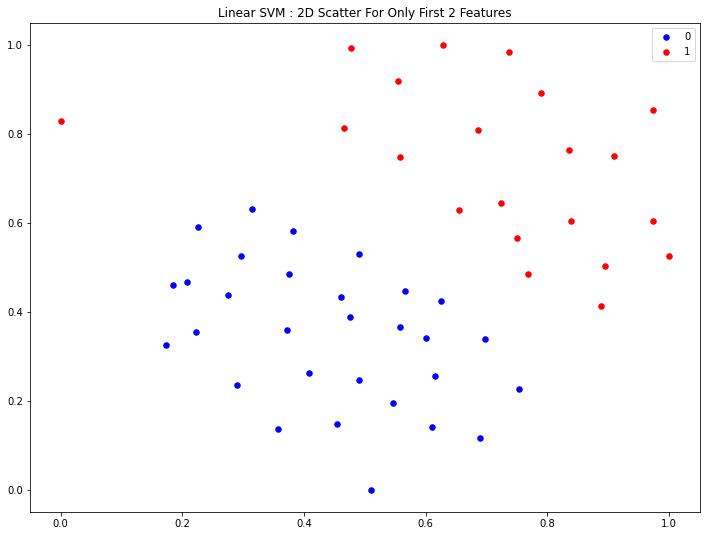

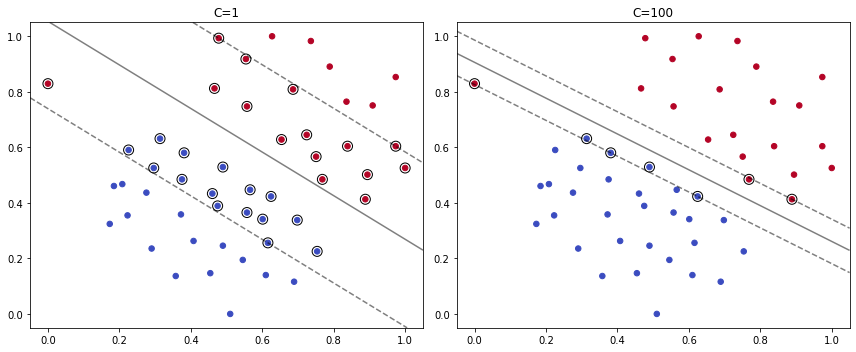

In [10]:
print('-----------------------------------------Linear SVM-----------------------------------------')
C = [1, 100]
x, y, n, k = get_data(set_type='Linear SVM')
classes = np.ravel(np.unique(y, axis=0)).astype(int)
print('x =', x.shape)
print('y =', y.shape)
print('n =', n)
print('k =', k)
print('classes =', classes)
print('C =', C)
h = PlotScatter2D(x, y, 'Linear SVM : 2D Scatter For Only First 2 Features')
LinearSVM(x, y, n, k, C)

------------------------------Kernel SVM for Two-Class problem (DataSet=Dataset2.mat)------------------------------
DataSet = Kernel SVM A1
x = (411, 2)
y = (411, 1)
n = 2
k = 2
classes = [0 1]
Folds = 10-Time-10-Fold
C = [0.01, 0.1, 1, 10, 100, 1000]
Best Accuracy is for C=10.0 : 0.9474147335488801


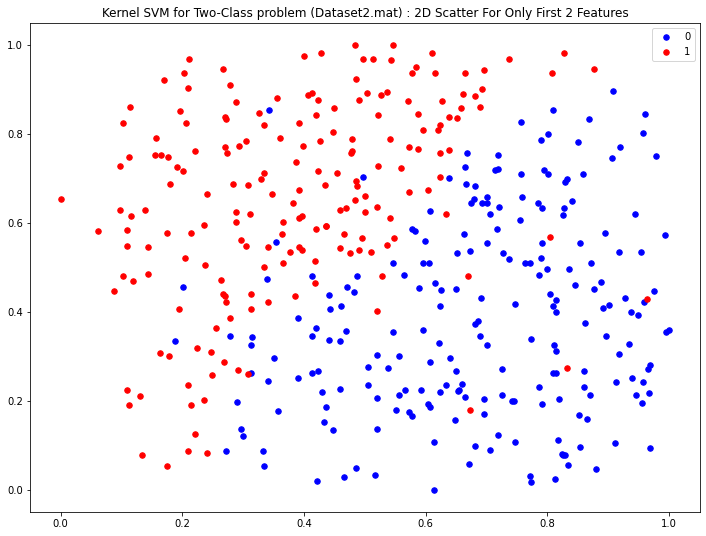

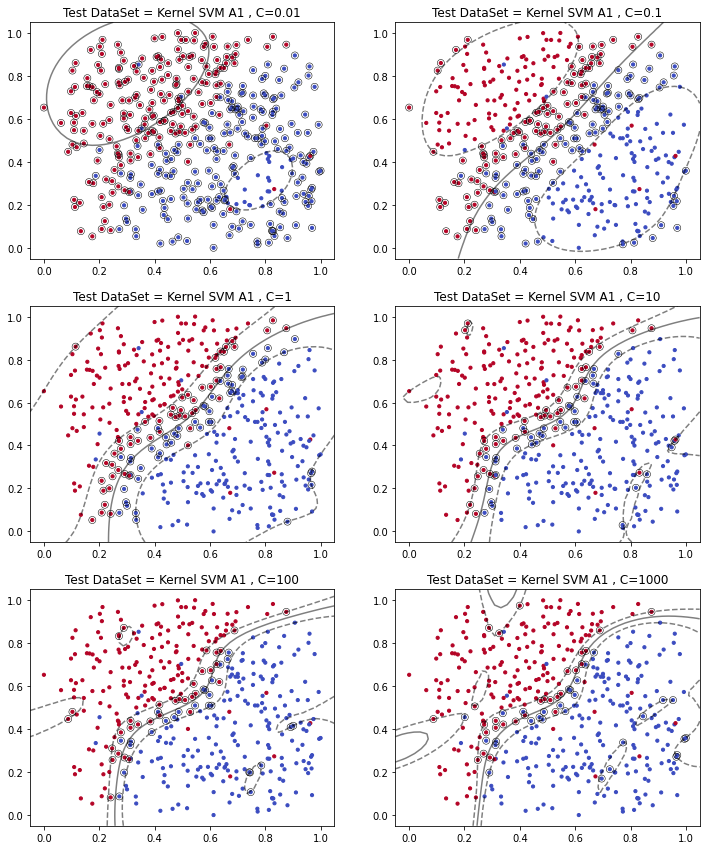

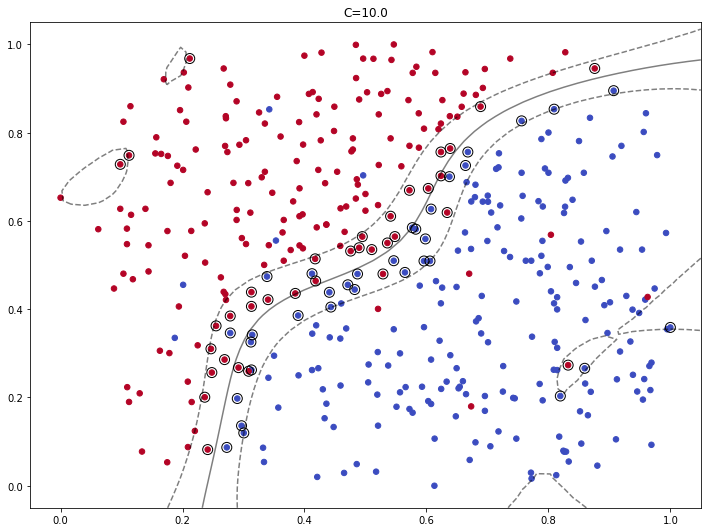

Average Train Accuracy for C's =  [0.78 0.94 0.95 0.95 0.95 0.95]
Average Test Accuracy for C's =  [0.78 0.93 0.94 0.94 0.94 0.94]


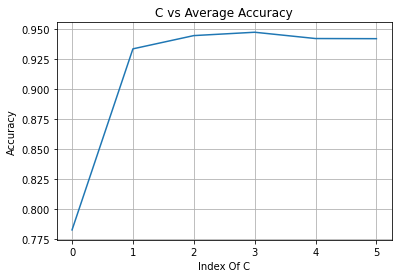

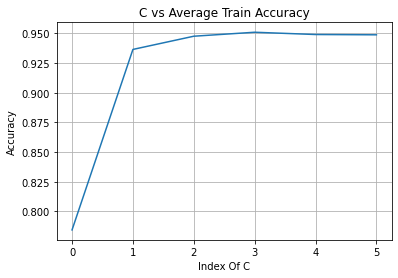

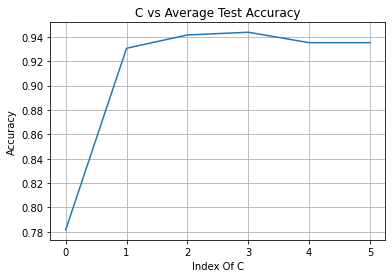

In [11]:
print('------------------------------Kernel SVM for Two-Class problem (DataSet=Dataset2.mat)------------------------------')
C = [0.01, 0.1, 1, 10, 100, 1000]
settype = 'Kernel SVM A1'
x, y, n, k = get_data(set_type=settype)
classes = np.ravel(np.unique(y, axis=0)).astype(int)
n_time = 10
n_fold = 10
print('x =', x.shape)
print('y =', y.shape)
print('n =', n)
print('k =', k)
print('classes =', classes)
print('Folds = ' + str(n_time) + '-Time-' + str(n_fold) + '-Fold')
print('C =', C)

h = PlotScatter2D(x, y, 'Kernel SVM for Two-Class problem (Dataset2.mat) : 2D Scatter For Only First 2 Features')
c_accuracy, results = KernelSVM(settype, x, y, n, k, C, n_time, n_fold, print_plots=True)
print("Average Train Accuracy for C's = ", np.round(np.mean(np.mean(results[:,:,:,0], axis=2), axis=1), 2) )
print("Average Test Accuracy for C's = ", np.round(np.mean(np.mean(results[:,:,:,1], axis=2), axis=1), 2) )
a = PlotResults(np.arange(0, len(C)), c_accuracy[:,1], 'C vs Average Accuracy')
b = PlotResults(np.arange(0, len(C)), np.mean(np.mean(results[:,:,:,0], axis=2), axis=1), 'C vs Average Train Accuracy')
c = PlotResults(np.arange(0, len(C)), np.mean(np.mean(results[:,:,:,1], axis=2), axis=1), 'C vs Average Test Accuracy')
plt.show()

------------------------------Kernel SVM for Two-Class problem (DataSet=Health.dat)------------------------------
DataSet = Kernel SVM A2
x = (270, 13)
y = (270, 1)
n = 13
k = 2
classes = [1 2]
Folds = 10-Time-10-Fold
C = [0.01, 0.1, 1, 10, 100, 1000]
Best Accuracy is for C=100.0 : 0.8937860082304526
Average Train Accuracy for C's =  [0.56 0.84 0.88 0.96 0.99 1.  ]
Average Test Accuracy for C's =  [0.56 0.82 0.82 0.8  0.79 0.77]


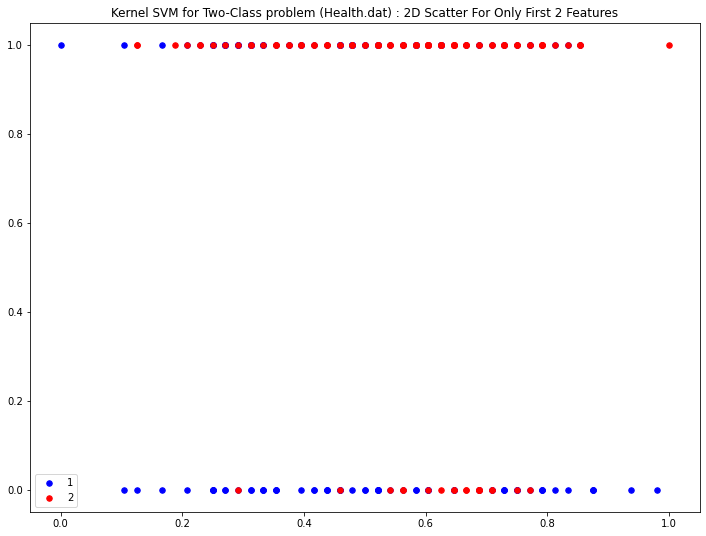

<Figure size 864x1440 with 0 Axes>

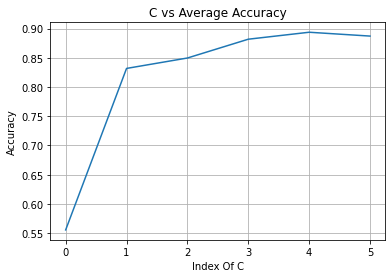

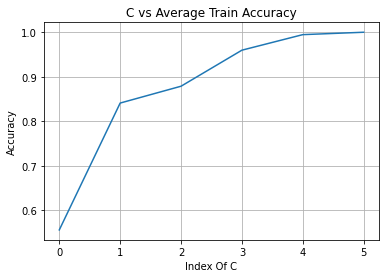

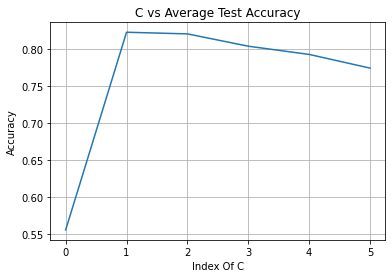

In [12]:
print('------------------------------Kernel SVM for Two-Class problem (DataSet=Health.dat)------------------------------')
C = [0.01, 0.1, 1, 10, 100, 1000]
settype = 'Kernel SVM A2'
x, y, n, k = get_data(set_type=settype)
classes = np.ravel(np.unique(y, axis=0)).astype(int)
n_time = 10
n_fold = 10
print('x =', x.shape)
print('y =', y.shape)
print('n =', n)
print('k =', k)
print('classes =', classes)
print('Folds = ' + str(n_time) + '-Time-' + str(n_fold) + '-Fold')
print('C =', C)

h = PlotScatter2D(x, y, 'Kernel SVM for Two-Class problem (Health.dat) : 2D Scatter For Only First 2 Features')
c_accuracy, results = KernelSVM(settype, x, y, n, k, C, n_time, n_fold, print_plots=False)
print("Average Train Accuracy for C's = ", np.round(np.mean(np.mean(results[:,:,:,0], axis=2), axis=1), 2) )
print("Average Test Accuracy for C's = ", np.round(np.mean(np.mean(results[:,:,:,1], axis=2), axis=1), 2) )
a = PlotResults(np.arange(0, len(C)), c_accuracy[:,1], 'C vs Average Accuracy')
b = PlotResults(np.arange(0, len(C)), np.mean(np.mean(results[:,:,:,0], axis=2), axis=1), 'C vs Average Train Accuracy')
c = PlotResults(np.arange(0, len(C)), np.mean(np.mean(results[:,:,:,1], axis=2), axis=1), 'C vs Average Test Accuracy')
plt.show()

------------------------------Kernel SVM for Multi-Class problem------------------------------
DataSet = Kernel SVM B
x = (94, 18)
y = (94, 1)
n = 18
k = 4
classes = [1 2 3 4]
Folds = 10-Time-10-Fold
C = [0.01, 0.1, 1, 10, 100, 1000, 10000]
Best Accuracy is for C=10000.0 : 0.837388888888889
Average Train Accuracy for C's =  [0.3  0.32 0.74 0.95 1.   1.   1.  ]
Average Test Accuracy for C's =  [0.3  0.3  0.61 0.7  0.67 0.67 0.67]


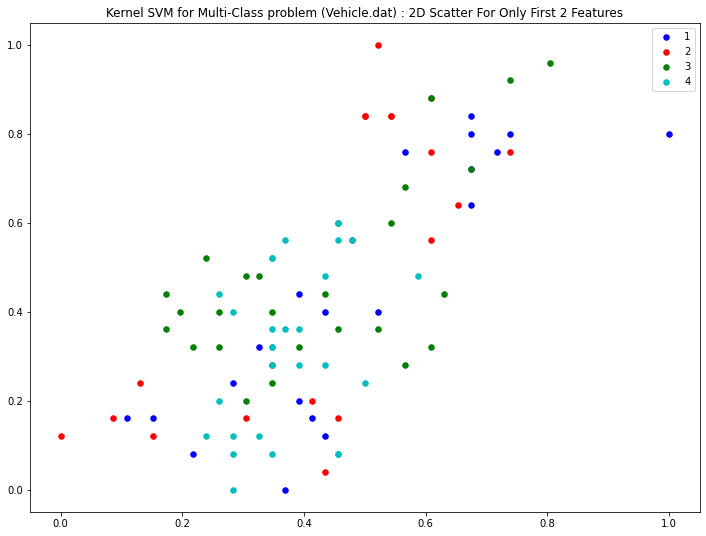

<Figure size 864x1440 with 0 Axes>

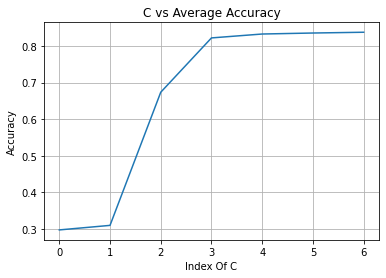

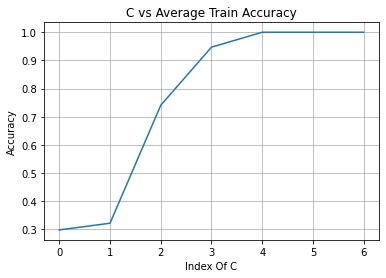

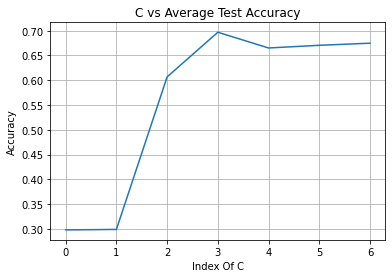

In [13]:
print('------------------------------Kernel SVM for Multi-Class problem------------------------------')
C = [0.01, 0.1, 1, 10, 100, 1000, 10000]
settype = 'Kernel SVM B'
x, y, n, k = get_data(set_type=settype)
classes = np.ravel(np.unique(y, axis=0)).astype(int)
n_time = 10
n_fold = 10
print('x =', x.shape)
print('y =', y.shape)
print('n =', n)
print('k =', k)
print('classes =', classes)
print('Folds = ' + str(n_time) + '-Time-' + str(n_fold) + '-Fold')
print('C =', C)

h = PlotScatter2D(x, y, 'Kernel SVM for Multi-Class problem (Vehicle.dat) : 2D Scatter For Only First 2 Features')
c_accuracy, results = KernelSVM_MultiClass(settype, x, y, n, k, C, n_time, n_fold, print_plots=False)
print("Average Train Accuracy for C's = ", np.round(np.mean(np.mean(results[:,:,:,0], axis=2), axis=1), 2) )
print("Average Test Accuracy for C's = ", np.round(np.mean(np.mean(results[:,:,:,1], axis=2), axis=1), 2) )
a = PlotResults(np.arange(0, len(C)), c_accuracy[:,1], 'C vs Average Accuracy')
b = PlotResults(np.arange(0, len(C)), np.mean(np.mean(results[:,:,:,0], axis=2), axis=1), 'C vs Average Train Accuracy')
c = PlotResults(np.arange(0, len(C)), np.mean(np.mean(results[:,:,:,1], axis=2), axis=1), 'C vs Average Test Accuracy')
plt.show()